# Multilabel Classification

In this notebook, we will look at the best practices for doing multilabel classification. 

Multi-class/Single-label classification assumes that each image is assigned to only one label: an animal can be either an dog or a cat but not both at the same time. Multi-label classification on the other hand, will assume that each image can contain or represent multiple different labels: a landscape can be labeled both gloomy (weather) and of a beach (subject).

In this notebook, we'll train a multilabel classifier and examine how best to structure data for multilabel classification problems as well as learn about new ways to evaluate our results.

Check our fast.ai version.

In [1]:
import fastai
fastai.__version__

'1.0.45'

Ensure edits to libraries are loaded and plotting is shown in the notebook. Also hide warnings.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Import fastai and other libraries needed. For now, we'll import all (`import *`) so that we can easily use different utilies provided by the fastai library.

In [3]:
from fastai.vision import *
import pandas as pd
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

---

## File Structure for Multilabel Image Classification

In this notebook, we'll look at different kinds of beverages. In the repo, under `image_classification/data` there is a directory titled: __multilabel_fridge_objects__. This is the data we'll use in this notebook.

Lets set that directory to our `path` variable, which we'll use throughout the notebook, and checkout what's inside:

In [4]:
path = Path('../data/multilabel_fridge_objects')
path.ls()

[PosixPath('../data/multilabel_fridge_objects/models'),
 PosixPath('../data/multilabel_fridge_objects/labels.csv'),
 PosixPath('../data/multilabel_fridge_objects/images')]

Lets inspect the `/images` folder:

In [5]:
(path/'images').ls()[:5]

[PosixPath('../data/multilabel_fridge_objects/images/16.jpg'),
 PosixPath('../data/multilabel_fridge_objects/images/98.jpg'),
 PosixPath('../data/multilabel_fridge_objects/images/66.jpg'),
 PosixPath('../data/multilabel_fridge_objects/images/76.jpg'),
 PosixPath('../data/multilabel_fridge_objects/images/33.jpg')]

Lets also take a look at the `labels.csv` file using pandas. 

In [6]:
df = pd.read_csv(path/'labels.csv'); df.sample(5)

filename                               labels
48    49.jpg              water_bottle carton can
86    87.jpg  carton can milk_bottle water_bottle
115  116.jpg                  water_bottle carton
62    63.jpg  carton can milk_bottle water_bottle
78    79.jpg  carton can milk_bottle water_bottle

As shown above, the contents of the csv file is a mapping of the filename to the labels. Since this is a multilabel classificaiton problem, each image can be associated to multiple labels.

Using the dataframe, lets show images where only one label is present. This will let us clearly see which object each label is associated to.

In [7]:
milk_bottle_fn = df.loc[df["labels"]=="milk_bottle", :]["filename"].values[0]
water_bottle_fn = df.loc[df["labels"]=="water_bottle", :]["filename"].values[0]
carton_fn = df.loc[df["labels"]=="carton", :]["filename"].values[0]
can_fn = df.loc[df["labels"]=="can", :]["filename"].values[0]

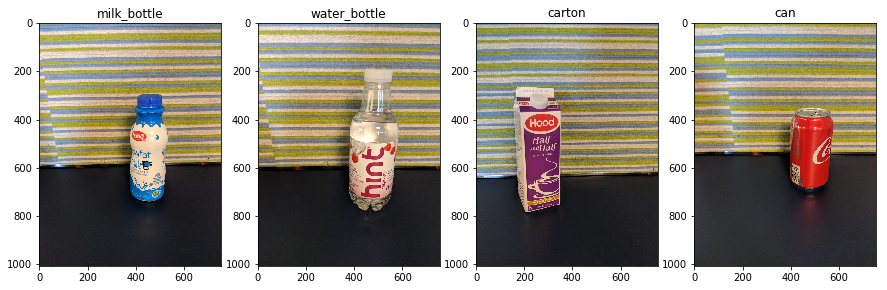

In [8]:
plt.figure(figsize=(15,8))

plt.subplot(1, 4, 1)
plt.title("milk_bottle")
plt.imshow(mpimg.imread(path/'images'/milk_bottle_fn))

plt.subplot(1, 4, 2)
plt.title("water_bottle")
plt.imshow(mpimg.imread(path/'images'/water_bottle_fn))

plt.subplot(1, 4, 3)
plt.title("carton")
plt.imshow(mpimg.imread(path/'images'/carton_fn))

plt.subplot(1, 4, 4)
plt.title("can")
plt.imshow(mpimg.imread(path/'images'/can_fn))

## Loading in labels and images with fast.ai

__Loading data__

Now that we know the structure of our data, lets use fast.ai's data block apis to create our databunches so that we can easily load mini-batches of data from our filesystem into our trainer.

In [9]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'labels.csv', folder='images')
       .random_split_by_pct(0.2)
       .label_from_df(label_delim=' '))

In [10]:
data = (src.transform(size=299)
        .databunch(bs=32)
        .normalize(imagenet_stats))

Lets break down the code:

The first thing we need to do is to create an `ImageItemList`, and we'll do so by creating it from a csv file (`from_csv`). Then we want to do a random split (`random_split_by_pct`) so that we have our validation set. For this method, we've also set a random seed (`np.random.seed(42)`) so that our validation set is consistent. Finally we want to get our labels from the df (`label_from_df`) that comes from the csv file. Since our labels are space-seperated in the csv file, we want to specify that our labels will be delimited by a space (`label_delim=' '`). 

In the second part, we use the `ImageItemList` we created and apply a transformation on it (`transform`) so that all images are resized to 299X299. Then we turn it into a databunch, which is basically the kind of object fastai's trainer uses to load mini-batches of data. Finally we'll normalize the databunch (`normalize(imagenet_states)` to the imagenet parameters.

__Inpsect data__

To make sure our data is correctly loaded, lets print out the number of classes, and each of the class labels.

In [11]:
data.c, data.classes

(4, ['can', 'carton', 'milk_bottle', 'water_bottle'])

We can also call `batch_stats` on our databunch object to get a view on how the data is split between training and validation.

In [12]:
data.batch_stats

<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (103 items)
x: ImageItemList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: MultiCategoryList
carton,milk_bottle,can,water_bottle,can
Path: ../data/multilabel_fridge_objects;

Valid: LabelList (25 items)
x: ImageItemList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: MultiCategoryList
carton;can;milk_bottle,water_bottle;carton;milk_bottle,water_bottle;can,milk_bottle;water_bottle;can,can
Path: ../data/multilabel_fridge_objects;

Test: None>

Lets get a sample of what the data looks like.

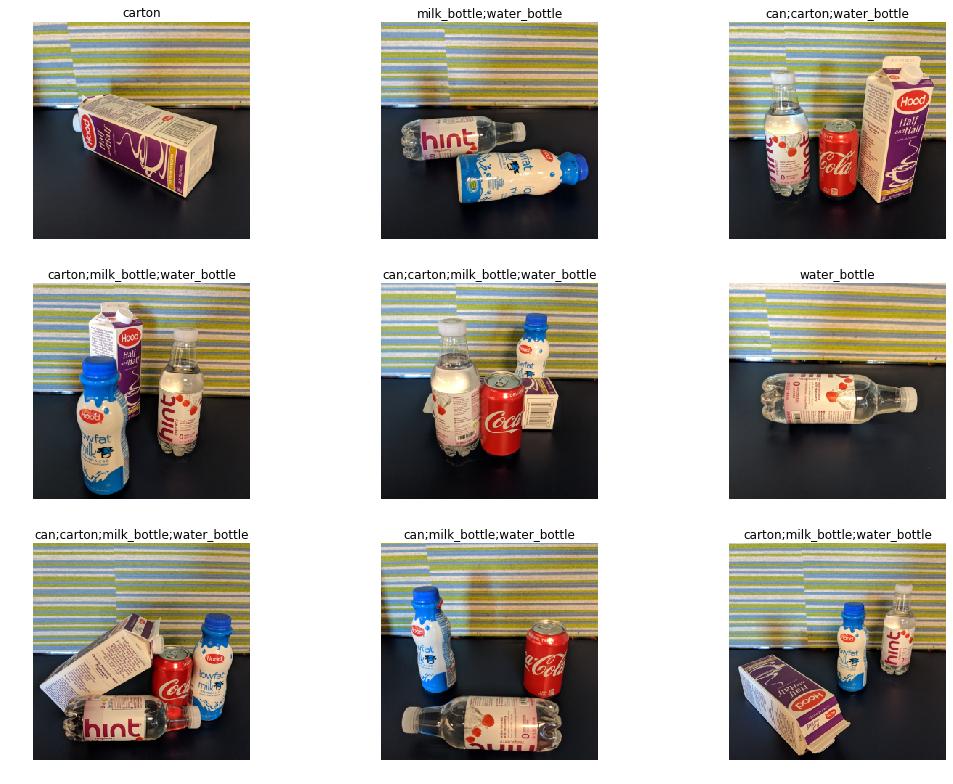

In [13]:
data.show_batch(rows=3, figsize=(15, 11))

## Training our multilabel classifier

One of the main differences between training a multilabel classifier an a single-label classifier is how we may want to evaluate our model.

In a single-label (multi-class) classification model, looking at a single metric like error rate (1 - accuracy), precision, etc is normally sufficient. 

However, for multilabel classification problems, a misclassification is not just a binary: right or wrong. Instead a prediction containing a subset of the labels we're looking for is better than one that contains none of them. For example, in an image that is labelled both 'rainy' and 'forest', it is better to predict one correct label than neither of the correct labels. Similarly, a prediction that makes a faulty prediction must also be penalized.

---

__Hamming Loss__

One of the most common ways to evaluate a multilabel classification problem is by using the Hamming loss, which we can think of as the fraction of wrong labels to the total number of labels. 

For example, lets say our validation data looks as such:
```
+------------------+------------------+
|  y_true:         |  y_pred:         |
|------------------+------------------+
|  [[1, 0, 0, 1],  |  [[1, 0, 0, 0],  |
|   [1, 0, 1, 1],  |   [1, 1, 1, 1],  |
|   [0, 1, 0, 0],  |   [0, 1, 0, 0],  |
|   [1, 1, 0, 0]]  |   [1, 1, 1, 0]]  |
+------------------+------------------+
```
In this case, the predictions has 3 out of a total of 16 predictions that are not true, so the hamming loss is __0.1875__.

---

For this notebook, we'll creating our own evaluation metric - Hamming Loss. To do this, we'll need to create a custom function that will takes a `y_pred` and a `y_true`, and returns a single metric.

While hamming loss is a common evaluation metric for multilabel classification, note that it may not be ideal for all multilabel classification problems. For each problem, you need to access what you're evaluating your model against to see if it is a good fit. Thus it is also useful to show below how you can create your own metrics to use with the trainer.

In [22]:
def hamming_loss(y_pred:Tensor, y_true:Tensor, thresh:int=0.2, sigmoid:bool=True):
    if sigmoid: y_pred = y_pred.sigmoid()
    if thresh: y_pred = y_pred > thresh
    return (y_pred.float()!=y_true).sum() / torch.ones(y_pred.shape).sum()

We'll use the `create_cnn` function to create our CNN, passing in our custom `hamming_loss` function.

In [25]:
learn = create_cnn(data, models.resnet50, metrics=[hamming_loss])

Lets get a good learning rate to train our model with.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03


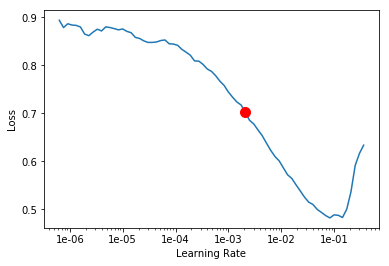

In [22]:
learn.lr_find()
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(5, 1e-3)

In [27]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


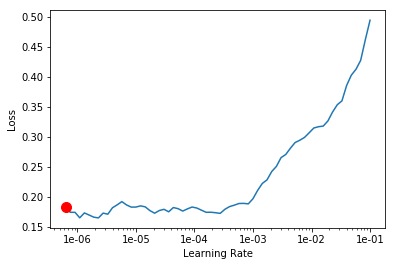

In [25]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(5, 1e-4)

## Evaluation

In fast.ai, the learner comes with a handy function `show_results` that will show one mini-batch of the validation set. We can use that to get a sense of what is being predicted correctly and what is not.

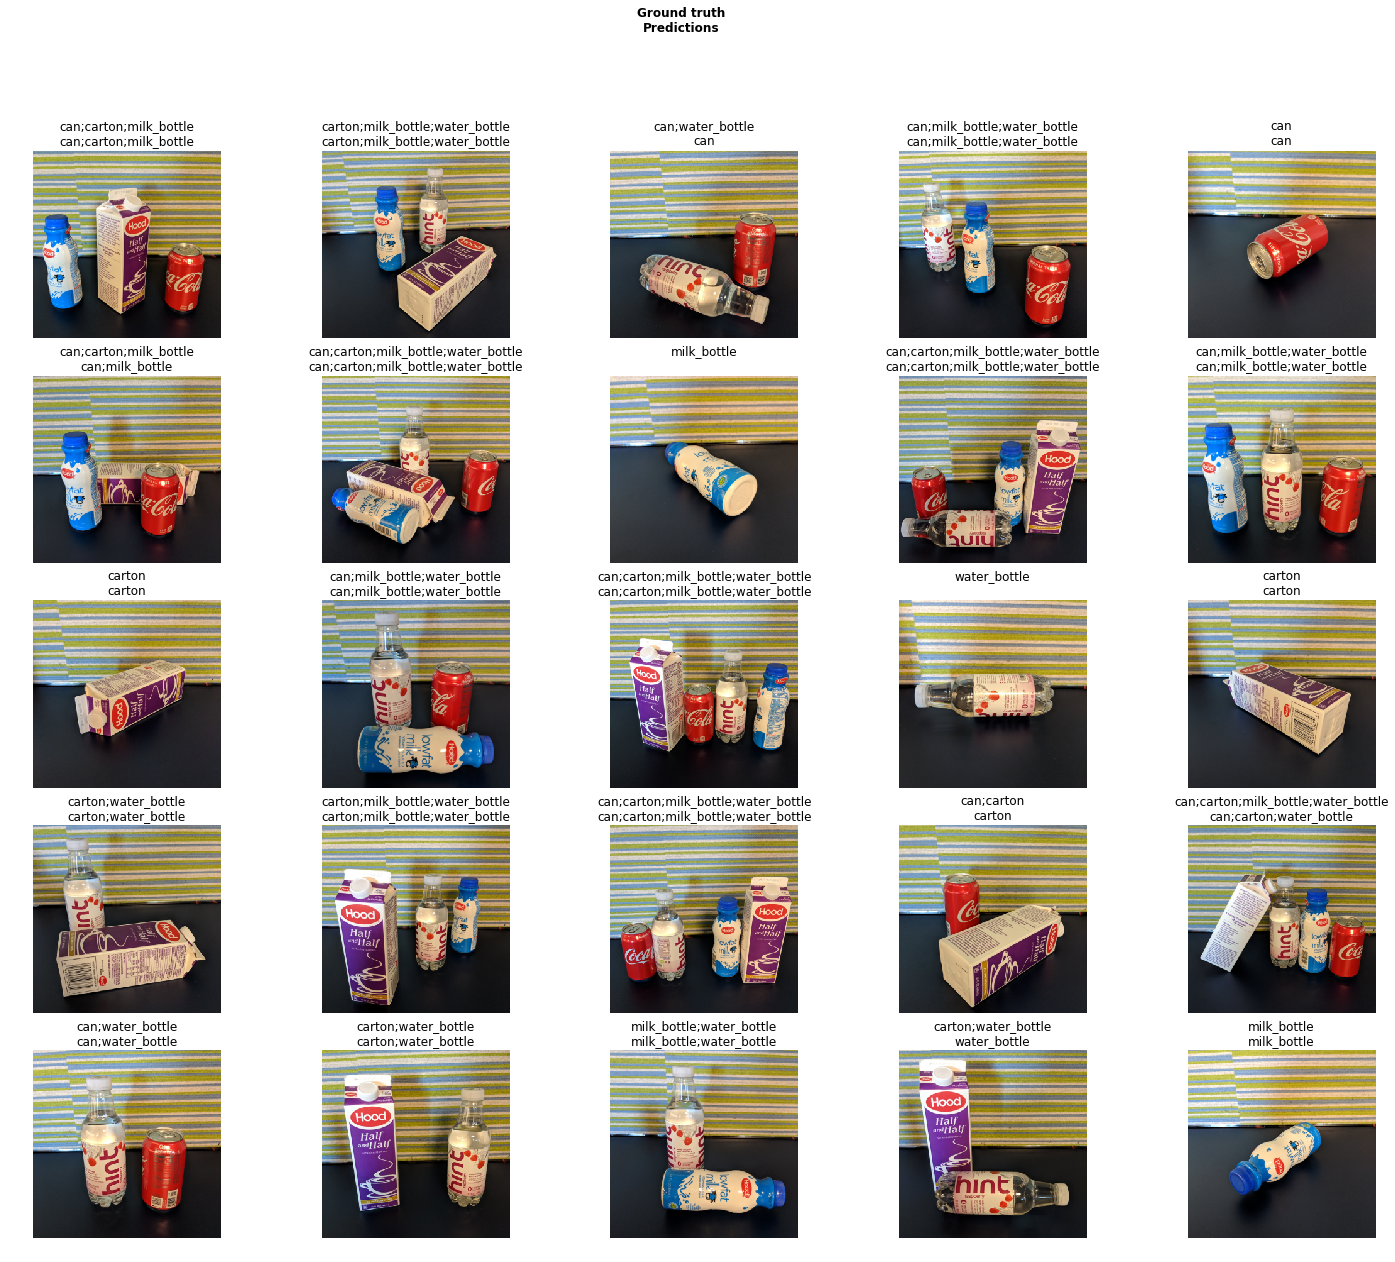

In [29]:
learn.show_results(rows=5, figsize=(25, 20))

Since we're only working with a relatively small dataset (validation set of 25 images), we might as well take a look at all 25 images to see if we can spot anything odd.

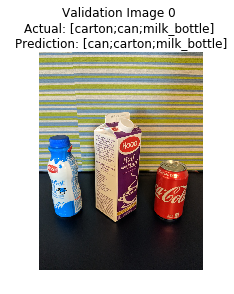

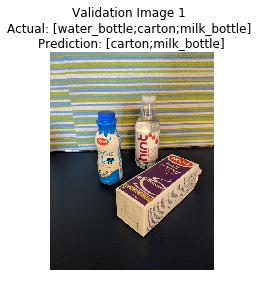

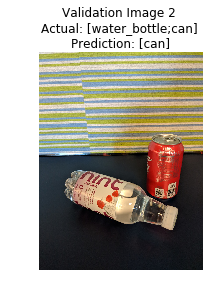

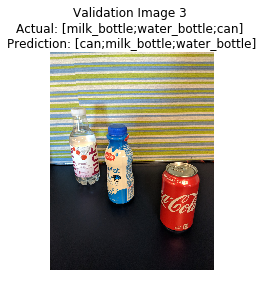

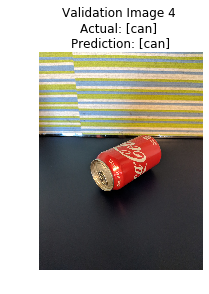

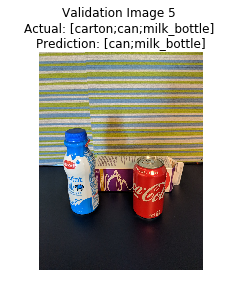

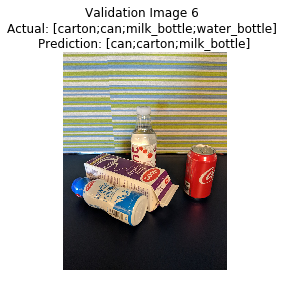

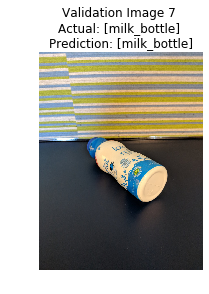

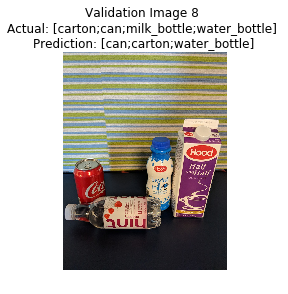

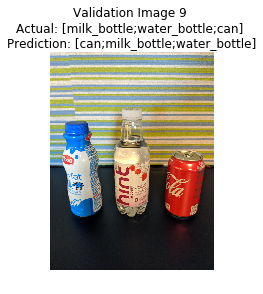

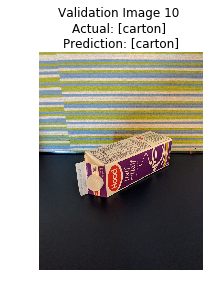

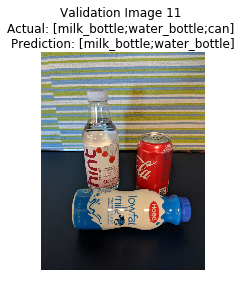

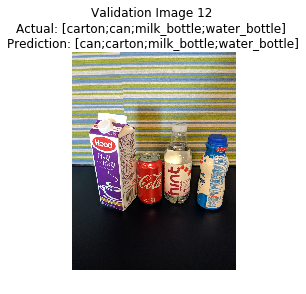

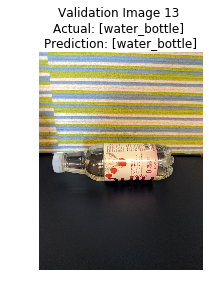

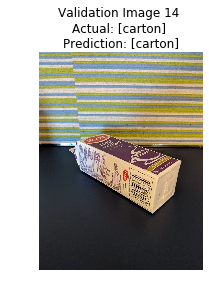

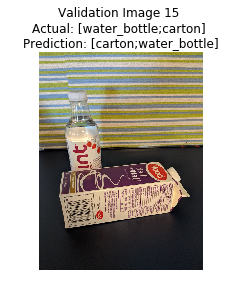

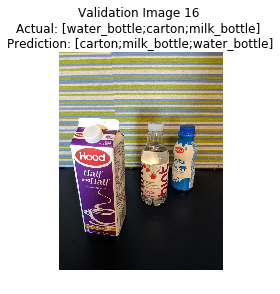

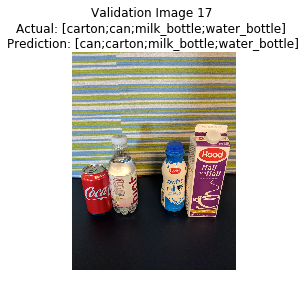

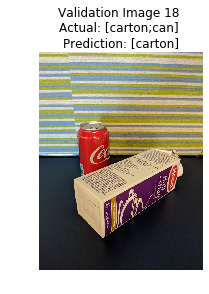

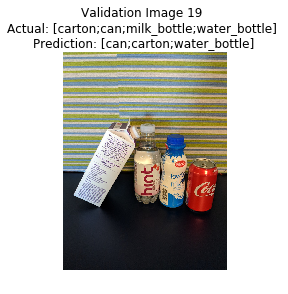

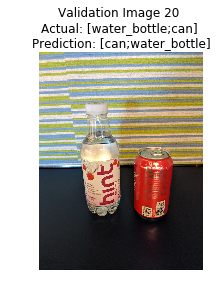

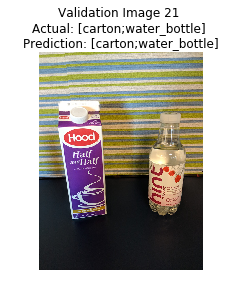

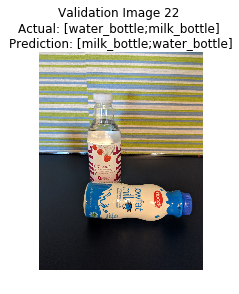

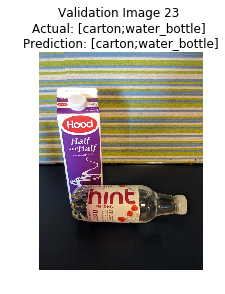

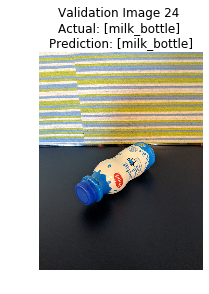

In [183]:
for i in range(len(data.valid_ds.x)):
    actual_labels = data.valid_ds.y[i]
    pred_labels = learn.predict(data.valid_ds.x[i])[0]
    data.valid_ds.x[i].show(
        figsize=(8, 4), 
        title=f'Validation Image {i} \nActual: [{actual_labels}] \nPrediction: [{pred_labels}]')

In our validation set, we have a total of 25 images, where each image can have 4 possible correct or incorrect labels. Since we're looking at hamming loss, we want to count the fraction of incorrect labels over the total labels (100, in this case). 

Lets do that manually.

In [68]:
total_errors = 0
total_predictions = 0
for i in range(len(data.valid_ds.x)):
    actual_labels = set(str(data.valid_ds.y[i]).split(";"))
    pred_labels = set(str(learn.predict(data.valid_ds.x[i])[0]).split(";"))
    total_errors += len(actual_labels.symmetric_difference(pred_labels))
    total_predictions += data.valid_ds.c
    
# hamming loss is the number of incorrect labels as a fraction of total predictions
print(f'''
The hamming loss is {total_errors/total_predictions}.
There were a {total_errors} errors out of a total {total_predictions} predictions.
''')


The hamming loss is 0.09.
There were a 9 errors out of a total 100 predictions.



---

## Learnings

1. Multilabel classification is similar to single-label classification in many ways, but we need to take into account that the data will likely be stored in a different format, and that we may want to choose a different evaluation metric.
1. We can define our own evaluation metrics, we just need to create a function that takes in a `y_pred` and `y_true`.
1. When it comes to evaluating our results, we can build our own utilities using the `data` object that we created